In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py 
import math
import glob
import os
import netCDF4 as cdf
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, interp
import scipy.stats as stats
from sklearn.decomposition import IncrementalPCA
from mpl_toolkits.basemap import Basemap
import warnings
from sklearn.metrics import mean_squared_error
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('classic')
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True,color='red')
from mpl_toolkits import axes_grid1
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [3]:
import sys
sys.path.insert(0, '/usr/people/botiabo/Fluor_retrieval/')
import config as con
import Retrieval.highsampling as high

# Create functions
mu_f    = 737. 
sigma_f = 33.9

def gauss(x, mu_f, sigma_f):
    return np.exp(-(x-mu_f)**2/(2.*sigma_f**2))

# Get parameters
def read_hdf_redo(fname):
    with h5py.File(fname) as outh:
        Fs  = outh['level2/param'][:,:]      # Convert from W to mW
        res = outh['level2/res'][:]
        wl  = outh['level2/wavelength'][:]
        sza = outh['level2/SZA'][:]
        vza = outh['level2/VZA'][:]
        lat = outh['level2/lat'][:]
        lon = outh['level2/lon'][:]
        cor = outh['level2/autocorrelation'][:]
        cf  = outh['level2/CloudFraction'][:]
    return(Fs,res,wl,sza,vza,lat,lon,cor, cf)


with h5py.File('/usr/people/kooreman/nobackup/data_SIFTER/M02/SIFTER2/SIFTER2_M02_EOF_2009_08') as pc_file:
    PCs = pc_file['EOF'][:,:]

d, res, wl, sza, vza, lat, lon, cor, cf = read_hdf_redo('/usr/people/kooreman/nobackup/data_SIFTER/M02/SIFTER2/Level2/2009/08/SIFTER2_M02_L2_2009_08_01')
wlp = np.asarray([wl**i for i in range(4+1)])

refspec = high.convolve_refspec()[1]
theta = lambda x: (x - 3)*2*np.pi/365
solspec = lambda x: refspec(x)*((1+0.01671022*np.cos(theta(354)))/(1+0.01671022*np.cos(theta(354))))**2
fluor = np.pi*gauss(wl, mu_f, sigma_f)/solspec(wl)

a = d[:,0]         # Fls (79506,)
b = d[:,1:6][:]    # polynomial coefficents (79506, 5)
c = d[:,6:][:]     # PCs coefficients  (79506, 10)
d = d[:,6:16][:]


In [5]:
d.shape

(79506, 10)

In [12]:
w_node = wl[117]

In [6]:
T = np.array((np.exp([-sum(c[i]*PCs[:,117]) for i in range(c.shape[0])])))
#T      = np.exp(-sum(c*PCs))

In [7]:
albedo = np.array([b[i]*wlp[:,117] for i in range(b.shape[0])])
albedo = np.sum(albedo, axis=1)
albedo.shape

(79506,)

In [15]:
a[nrs].shape

(45,)

In [16]:
# Selection of places in the Sahara

nrs = np.where((lat > 23) & (lat < 26) & (lon > 8) & (lon < 13) & (cor.reshape(len(cor), 1) < 0.2))[0]
#nrs2 = np.where((lat > 23) & (lat < 26) & (lon > 25) & (lon < 29) & (cor.reshape(len(cor), 1) < 0.2))[0]
#nrs3 = np.where((lat > 26) & (lat < 30) & (lon > 37) & (lon < 40) & (cor.reshape(len(cor), 1) < 0.2))[0]

In [17]:
sel_lat = lat[nrs]
sel_lon = lon[nrs]
sel_alb = albedo[nrs] 

#sel_lat2 = lat[nrs2]
#sel_lon2 = lon[nrs2]
#sel_alb2 = albedo[nrs2] 

#sel_lat3 = lat[nrs3]
#sel_lon3 = lon[nrs3]
#sel_alb3 = albedo[nrs3] 

In [18]:
print sel_alb[7], sel_lat[7], sel_lon[7]

0.456289427678 [ 24.953906] [ 11.981741]


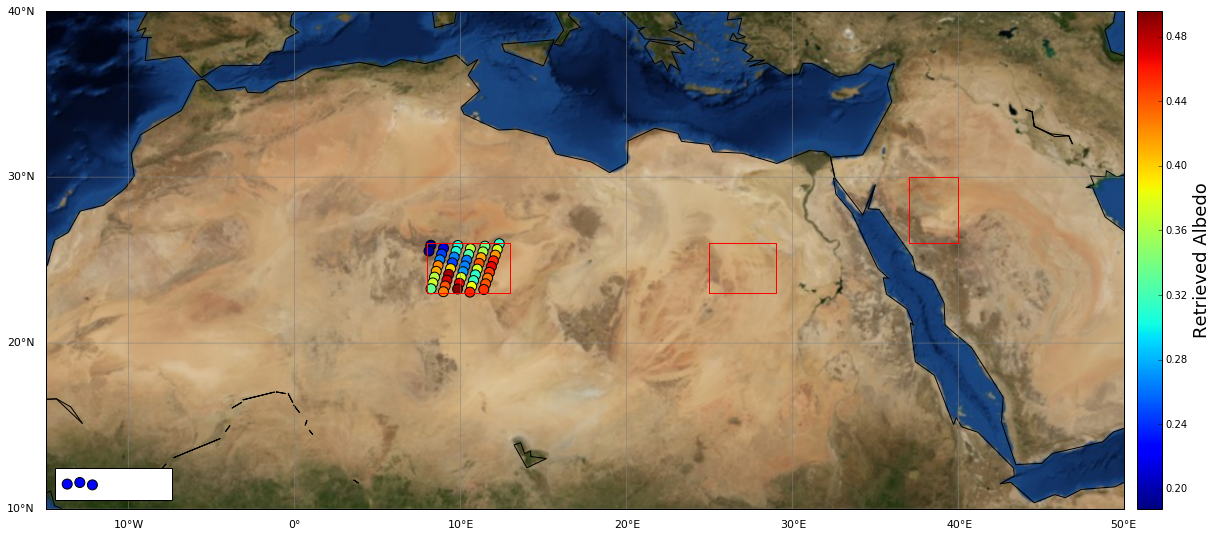

In [20]:
fig   = plt.figure(1,figsize=(20,20))

lllat        = 10
urlat        = 40
lllon        = -15
uprlon       = 50

map   = Basemap(projection='cyl',llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=uprlon)

x,y = map(sel_lon,sel_lat)
xx,yy = map(sel_lon2,sel_lat2)
xxx,yyy = map(sel_lon3,sel_lat3)

plt.subplot(111)
sc     = plt.scatter(x,y,c=sel_alb,cmap='jet',marker='o',s=100,label='Pixels')
#scc    = plt.scatter(xx,yy,c=sel_alb2,cmap='jet',marker='o',s=100,label='Pixels')
#sccc   = plt.scatter(xxx,yyy,c=sel_alb3,cmap='jet',marker='o',s=100,label='Pixels')
#sc.set_clim(vmin=0, vmax=1)
cb    = add_colorbar(sc)
#plt.title('GOME2a and Gome2b %i-%i - Matched Obs = %i'%(year,month,len(lon_listA)),fontsize=18)
cb.set_label('Retrieved Albedo',fontsize=18)
leg = plt.legend(loc='lower left',fontsize=18)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
map.drawmeridians(np.arange(-180,180,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
#map.drawcountries()
map.bluemarble()
plot_rectangle(map,25,29,23,26)
plot_rectangle(map,8,13,23,26)
plot_rectangle(map,37,40,26,30)
plt.show()

In [19]:
d[:,0].shape

(79506,)

(79506, 1)
(79506, 1)
(79506,)
(79499,) (79481,)


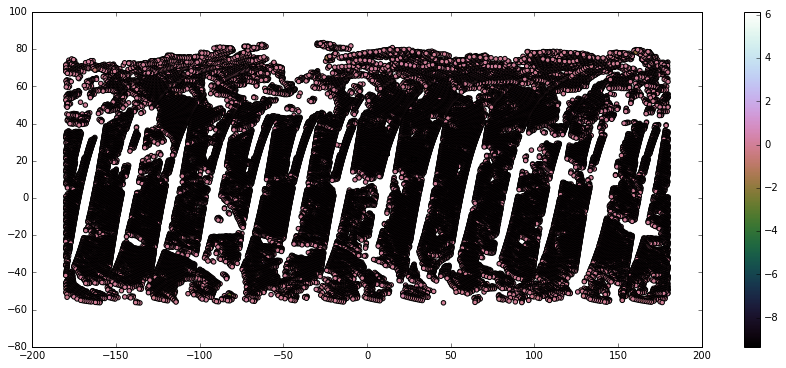

In [23]:
print lat.shape
print lon.shape
print albedo.shape
print np.unique(lon).shape, np.unique(lat).shape

fig = plt.figure(1,figsize=(15,6))
plt.scatter(lon,lat,c=d[:,1],cmap='cubehelix')
#plt.scatter(lon[nrs],lat[nrs],c=albedo[nrs],cmap='cubehelix')
#plt.scatter(lon[nrs2],lat[nrs2],c=albedo[nrs2],cmap='cubehelix')
plt.plot([8,8],[23,26],color='k')
plt.plot([13,13],[23,26],color='k')
plt.plot([8,13],[23,23],color='k')
plt.plot([8,13],[26,26],color='k')

plt.plot([26,26],[20,22],color='k')
plt.plot([29,29],[20,22],color='k')
plt.plot([26,29],[20,20],color='k')
plt.plot([26,29],[22,22],color='k')

plt.colorbar()
#plt.clim(0,1)
#plt.label('Surface LER')
#plt.xlim(-20,70,5)
#plt.ylim(10,40)
plt.show()
#plot_rectangle(map,26,29,20,22)
#plot_rectangle(map,8,13,23,26)

In [27]:
def read_hdf_redo_ler(fname):
    with h5py.File(fname) as outh:
        flag    = outh['Flag'][:]   
        lat     = outh['Latitude'][:] 
        lon     = outh['Longitude'][:] 
        min_ler = outh['Minimum_LER'][:] 
        mod_ler = outh['Mode_LER'][:]
        per     = outh['Period'][:]
        unc     = outh['Uncertainty'][:]
        wav     = outh['Wavelength'][:]
    return(flag,lat,lon, min_ler,mod_ler,per,unc,wav)

fname = 'GOME-2_MetOp-A_MSC_025x025_surface_LER_v2.1.hdf5'

flag,lat_ler,lon_ler,min_ler,mod_ler,per,unc,wav = read_hdf_redo_ler(fname)   


In [28]:
refspec = high.convolve_refspec()[1]
theta = lambda x: (x - 3)*2*np.pi/365
solspec = lambda x: refspec(x)*((1+0.01671022*np.cos(theta(354)))/(1+0.01671022*np.cos(theta(354))))**2

In [32]:
# to change month - change month in month, in file, an date 
filee = '/usr/people/kooreman/nobackup/data_SIFTER/M02/SIFTER2/Level2/2009/04/SIFTER2_M02_L2_'

month    = 4
wav_node = 19

fs     = []
alb_an = []
sza_m  = [] 
vza_m  = []
alb_ti = []
alb_si = []
days   = []
latit  = []
longi  = []

thresh = 0.1
cont   = 0

for t in range(1,3):
    day = str(t).zfill(2)
    date= '2009_04_%s'%(day)
    print filee+date
    
    d, res, wl, sza, vza, lat, lon, cor, cf = read_hdf_redo(filee+date)
    
    wlp = np.asarray([wl**i for i in range(4+1)])
    fluor = np.pi*gauss(wl, mu_f, sigma_f)/solspec(wl)

    a = d[:,0]         # Fls (79506,)
    b = d[:,1:6][:]    # polynomial coefficents (79506, 5)
    c = d[:,6:][:]     # PCs coefficients  (79506, 10)

    nrs = np.where((lat > 23) & (lat < 26) & (lon > 8) & (lon < 13) & (cor.reshape(len(cor), 1) < 0.2))[0]
    albedo = np.array([b[i]*wlp[:,117] for i in range(b.shape[0])])
    try:
        albedoo = np.sum(albedo, axis=1)  
    except:
        continue
    
    sel_lat = lat[nrs]
    sel_lon = lon[nrs]
    sel_alb = albedoo[nrs] 
    sel_vza = vza[nrs]
    sel_sza = sza[nrs]
    sel_fs  = a[nrs]
    sel_lat = lat[nrs] 
    sel_lon = lon[nrs]
    sel_cf  = cf[nrs]
    
    for k in range(len(nrs)):
        alb_sif = sel_alb[k]
        lat_sif = sel_lat[k]
        lon_sif = sel_lon[k]
        
        for i in range(len(lat_ler)):
            for j in range (len(lon_ler)):
                if abs(lat_ler[i]-lat_sif) < thresh and  abs(lon_ler[j]-lon_sif) < thresh:
                    cont += 1
                    fs.append(sel_fs[k]*1000)
                    alb_an.append(alb_sif-mod_ler[i,j,wav_node,month])
                    sza_m.append(sel_sza[k])
                    alb_si.append(alb_sif)
                    alb_ti.append(mod_ler[i,j,wav_node,month])
                    vza_m.append(sel_vza[k])
                    days.append(int(day))
                    latit.append(lat_sif)
                    longi.append(lon_sif)
                    print cont,nrs[k],alb_sif,mod_ler[i,j,wav_node,month],np.rad2deg(sel_sza[k]),cf[k],sel_fs[k]*1000
                    #abs(lat_ler[i]-lat_sif), abs(lon_ler[j]-lon_sif)

/usr/people/kooreman/nobackup/data_SIFTER/M02/SIFTER2/Level2/2009/04/SIFTER2_M02_L2_2009_04_01
1 24588 0.600795167473 0.602735 [ 45.701447] [ 0.0272562] -1.9087017397
/usr/people/kooreman/nobackup/data_SIFTER/M02/SIFTER2/Level2/2009/04/SIFTER2_M02_L2_2009_04_02
2 27459 0.375195059342 0.37164 [ 30.800709] [ 0.117938] -0.392045080597
3 27460 0.412975672833 0.37164 [ 31.481752] [ 0.07918458] 1.2768286336
4 27495 0.505689056497 0.463765 [ 30.548962] [ 0.12372825] 0.0982447442971
5 27534 0.594399044367 0.502532 [ 30.994608] [ 0.19402497] -0.971978508951
6 27535 0.541983827959 0.411979 [ 31.679315] [ 0.04596779] -1.91144032913
7 27556 0.374847907127 0.411979 [ 32.246491] [ 0.0556238] -0.665474333142


In [87]:
dataf = pd.DataFrame()

dataf['lat'] = latit
dataf['lon'] = longi
dataf['days'] = np.array(days)
dataf['Fs'] = np.array(fs)
dataf['Albedo Anomaly'] = np.array(alb_an)
dataf['Albedo Sif'] = np.array(alb_si)
dataf['Albedo Tilstra'] = np.array(alb_ti)
dataf['SZA'] = np.array(sza_m)
dataf['SZAangle'] = np.rad2deg(dataf['SZA'])

In [88]:
dataf.to_pickle('albedo_sza_tilstra_2009_04')

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in arccos


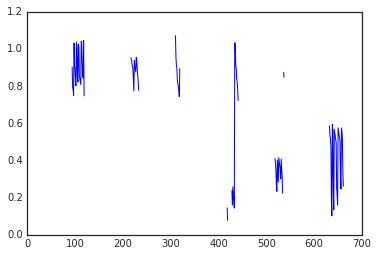

In [39]:
dataf_aug = pd.read_pickle('albedo_sza_tilstra_2009_08')
dataf_jan = pd.read_pickle('albedo_sza_tilstra_2009_01')

In [ ]:
#sns.jointplot(dataf_aug['Albedo Anomaly'].loc[dataf_aug['Fs']<0],dataf_aug['Fs'].loc[dataf_aug['Fs']<0],kind='reg')
#sns.jointplot(dataf_jan['Albedo Anomaly'].loc[dataf_jan['Fs']<0],dataf_jan['Fs'].loc[dataf_jan['Fs']<0],kind='reg')

#sns.jointplot(dataf_aug['Albedo Anomaly'],dataf_aug['Fs'],kind='reg')
#sns.jointplot(dataf_jan['Albedo Anomaly'],dataf_jan['Fs'],kind='reg')


# Filtering Fs values for A and B according to 2 stds


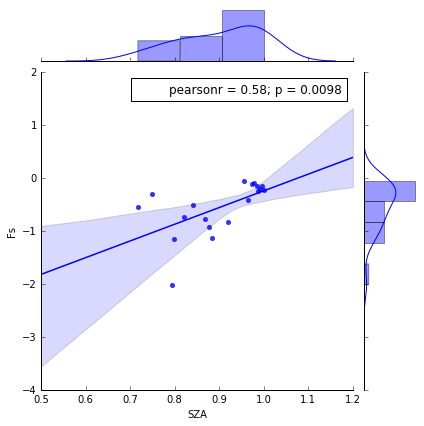

In [125]:
sns.jointplot(dataf['SZA'].loc[(dataf['SZA']<1) & (dataf['Fs']<0)],dataf['Fs'].loc[(dataf['SZA']<1) & (dataf['Fs']<0)],kind='reg')

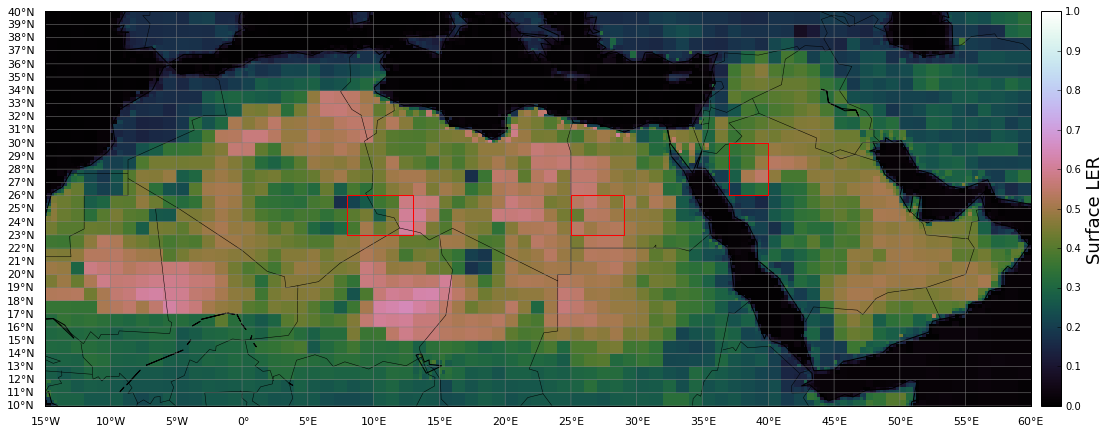

In [51]:
plot         = mod_ler # mod_ler 
month        = 8
wav_node     = 19

zoom         = True
xx, yy       = np.meshgrid(np.arange(-180,180,0.25),np.arange(-90,90,0.25))
fig          = plt.figure(1,figsize=(15,15))
if not zoom:
    map      = Basemap(projection='cyl', lat_0=0, lon_0=0)
if zoom: 
    map      = Basemap(projection='cyl',llcrnrlat=10, urcrnrlat=40, llcrnrlon=-15, urcrnrlon=60)

fig          = plt.figure(1,figsize=(15,15))
ax           = fig.add_subplot(111)
imm          = map.pcolormesh(xx,yy,plot[:,:,wav_node,month],cmap='cubehelix') # GnBU,Jet,coolwarm
cb           = add_colorbar(imm)

imm.set_clim(vmin=0, vmax=1)
cb.set_label('Surface LER',fontsize=18)
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(-90,90,1),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
map.drawmeridians(np.arange(-180,180,5),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
#map.bluemarble()
fig.tight_layout()
plot_rectangle(map,25,29,23,26)
plot_rectangle(map,8,13,23,26)
plot_rectangle(map,37,40,26,30)
plt.show()

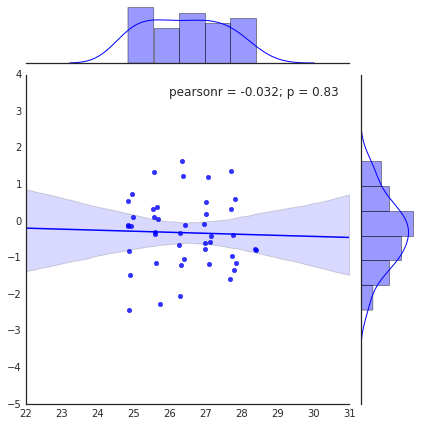

-0.322546313637


In [81]:
with h5py.File('/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/08/SIFTER2_M02_L2_2009_08_01') as outh:
    Fs  = outh['level2/param'][:,:]      # Convert from W to mW
    res = outh['level2/res'][:]
    wl  = outh['level2/wavelength'][:]
    sza = outh['level2/SZA'][:]
    vza = outh['level2/VZA'][:]
    lat = outh['level2/lat'][:]
    lon = outh['level2/lon'][:]
    cor = outh['level2/autocorrelation'][:]
    cf  = outh['level2/CloudFraction'][:]
    alt = outh['level2/height'][:]
#nrs = np.where((lat > 20) & (lat < 22) & (lon > 26) & (lon < 29) & (cor.reshape(len(cor), 1) < 0.2))[0]
#nrs = np.where((lat > 23) & (lat < 26) & (lon > 8) & (lon < 13) & (cor.reshape(len(cor), 1) < 0.2))[0]
nrs = np.where((lat > 23) & (lat < 26) & (lon > 8) & (lon < 13) )[0]
sns.jointplot(np.rad2deg(sza[nrs,0]), Fs[nrs,0]*1000., kind='reg')
plt.show()
print((Fs[nrs,0]*1000.).mean())

/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_01


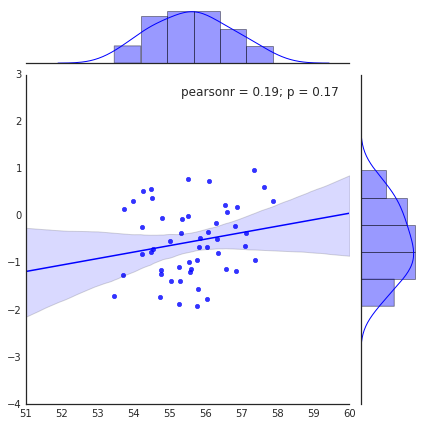

-0.553860256797
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_02


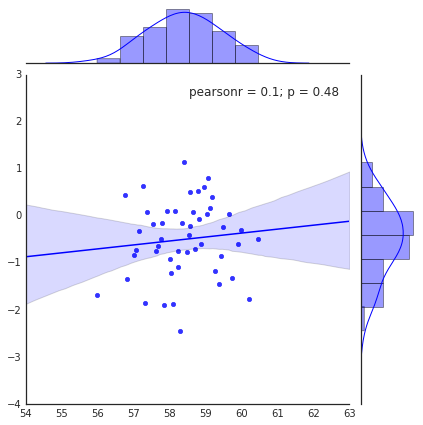

-0.505113424003
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_03


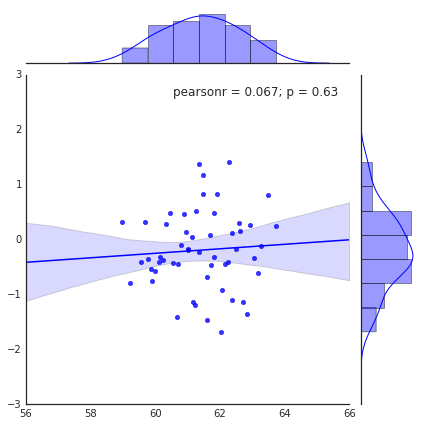

-0.200007371737
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_04


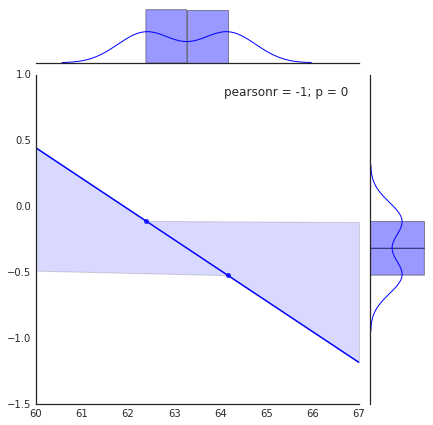

-0.317341301887
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_05


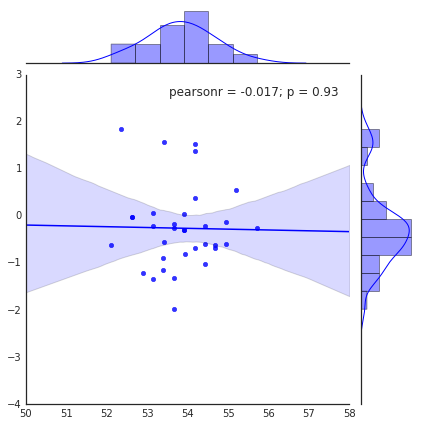

-0.266770807809
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_06
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_07


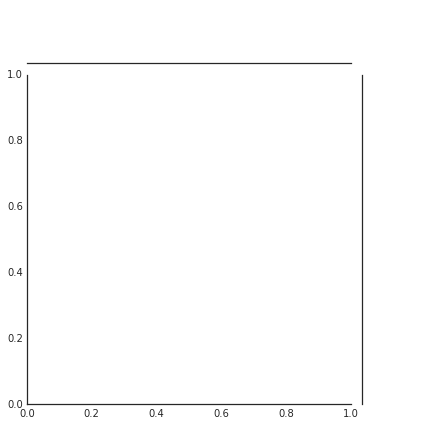

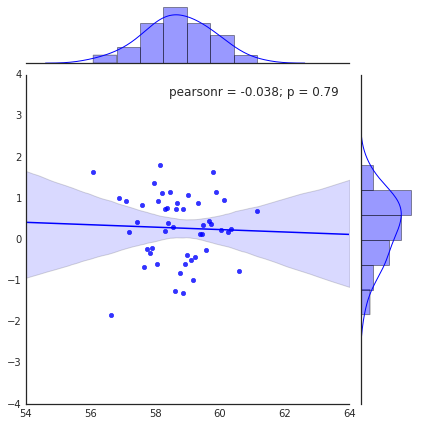

0.271136537166
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_08


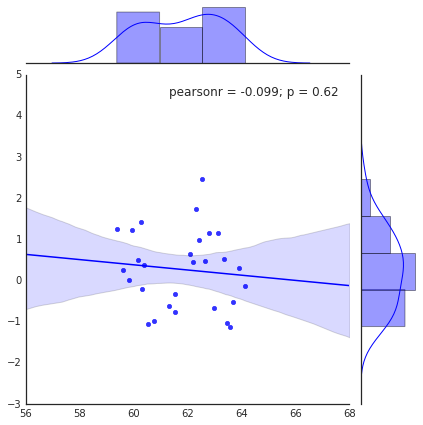

0.262764934492
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_09
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_10


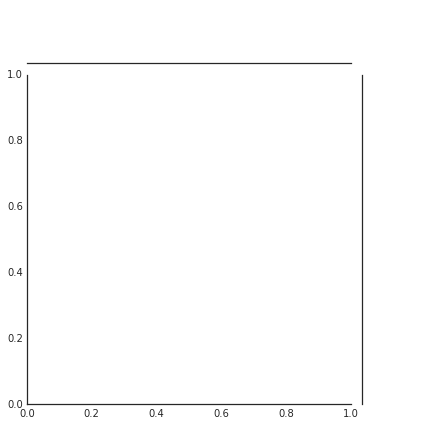

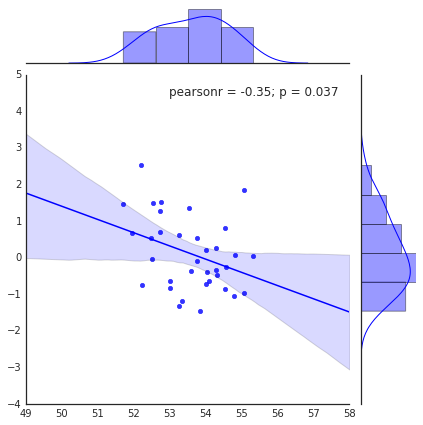

0.0985470759256
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_11


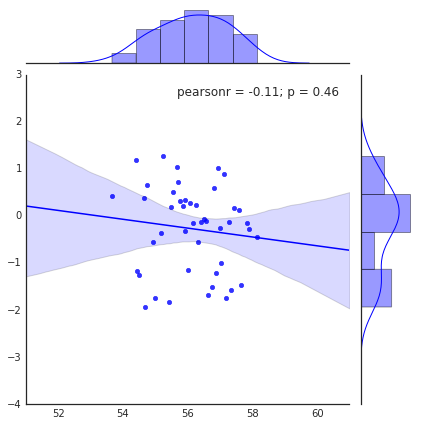

-0.278687188147
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_12


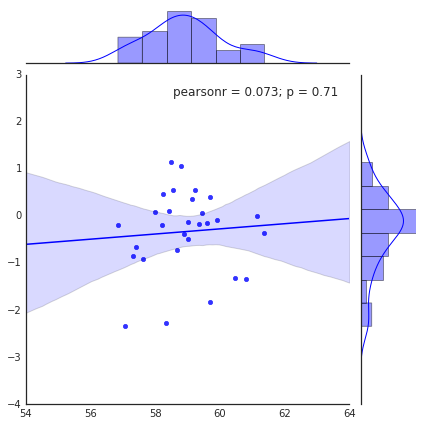

-0.340133442223
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_13


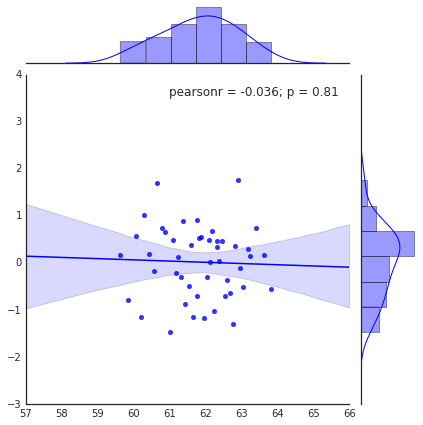

0.0127877523746
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_14
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_15


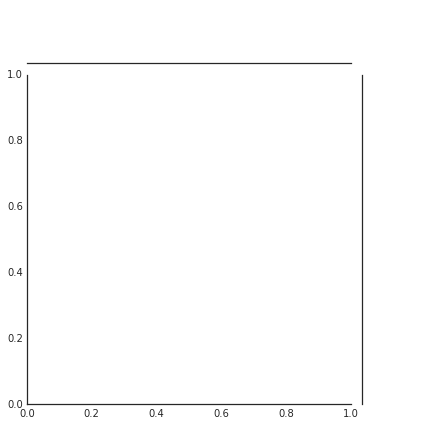

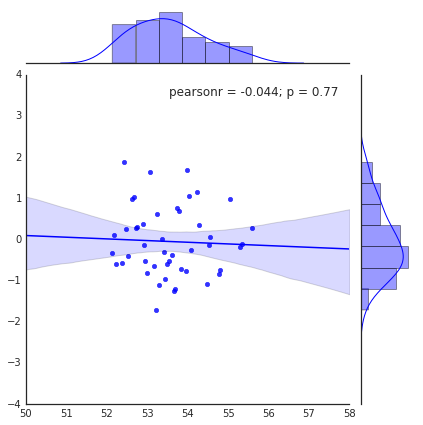

-0.0567235318184
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_16


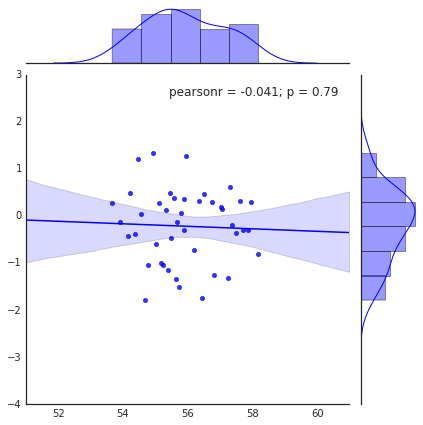

-0.223885249579
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_17


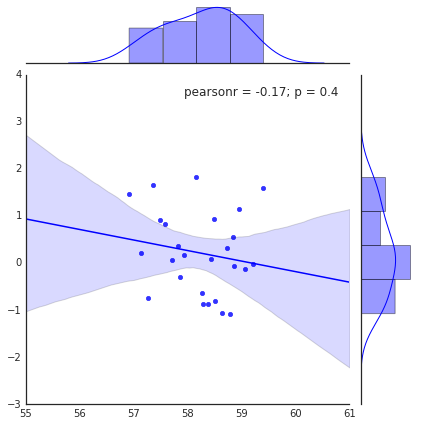

0.20520236757
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_18


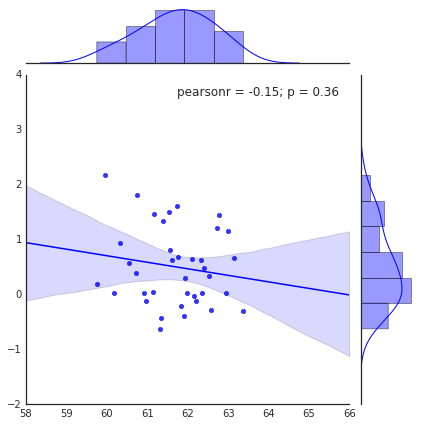

0.495423546604
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_19
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_20


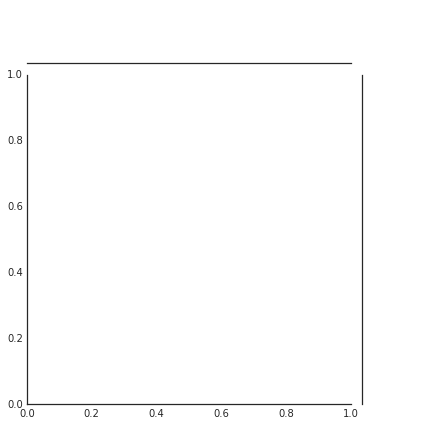

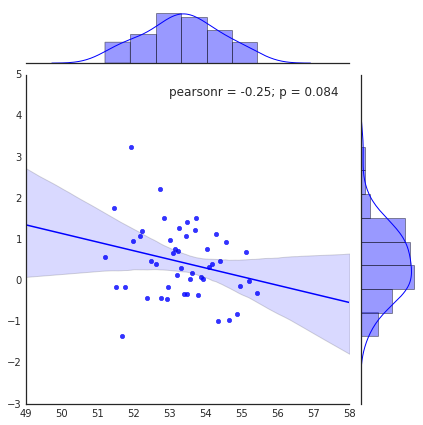

0.439260894873
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_21


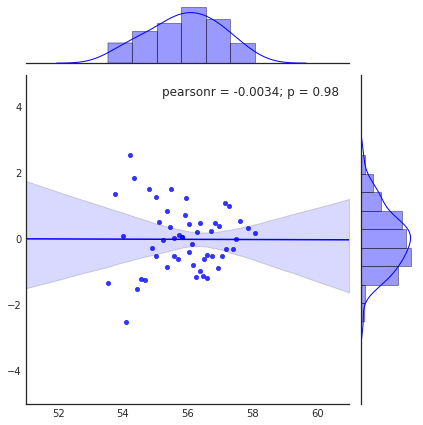

-0.00477738384391
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_22


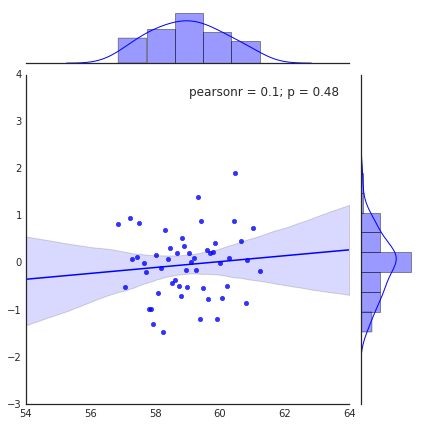

-0.0401617228222
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_23


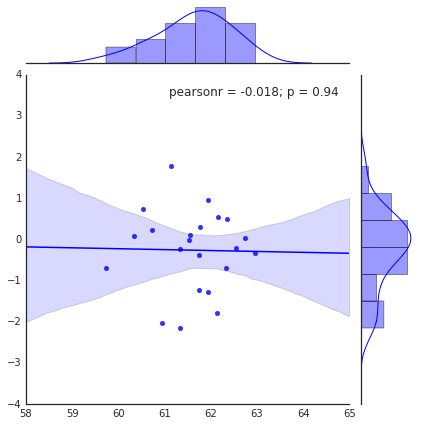

-0.267739835294
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_24


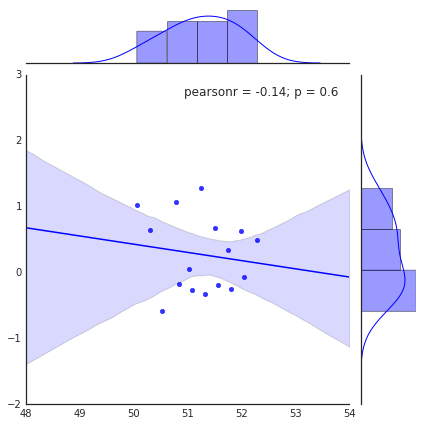

0.267326395302
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_25


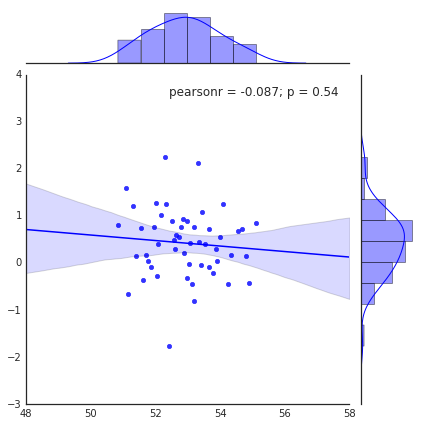

0.417577049217
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_26


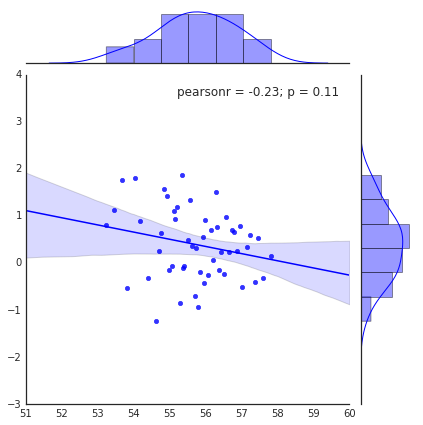

0.387169878591
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_27
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_28


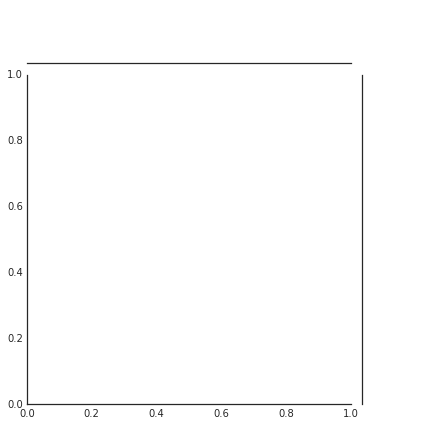

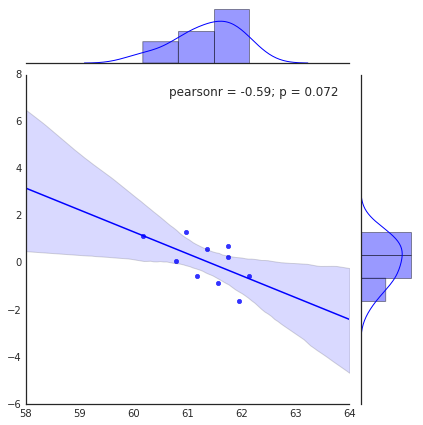

0.044002446556
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_29


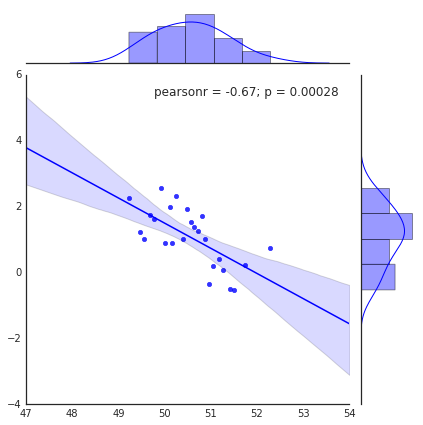

1.05636847549
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_30


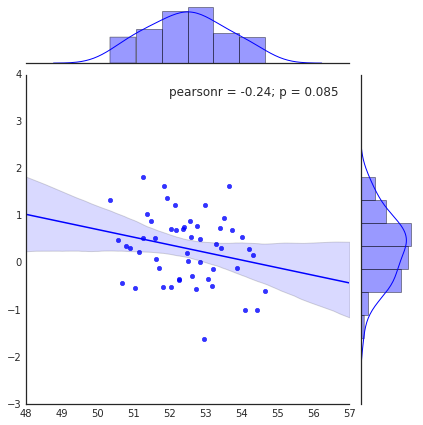

0.302399532275
/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_2009_01_31


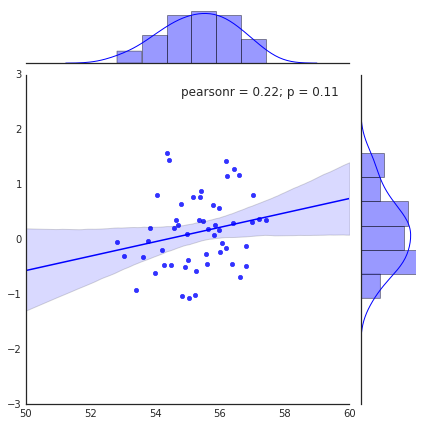

0.128094352077


In [89]:
filee = '/usr/people/kooreman/nobackup/data_SIF/M02/SIFTER2/Level2/2009/01/SIFTER2_M02_L2_'

for t in range(1,32):
    day = str(t).zfill(2)
    date= '2009_01_%s'%(day)
    print filee+date
    
    d, res, wl, sza, vza, lat, lon, cor = read_hdf_redo(filee+date)
    
    #nrs = np.where((lat > 23) & (lat < 26) & (lon > 8) & (lon < 13) )[0]
    nrs = np.where((lat > 23) & (lat < 26) & (lon > 8) & (lon < 13) & (cor.reshape(len(cor), 1) < 0.2))[0]
    try:
        sns.jointplot(np.rad2deg(sza[nrs,0]), d[nrs,0]*1000., kind='reg')
    except:continue
    plt.show()
    print((d[nrs,0]*1000.).mean())